# Primeiro Trabalho Prático de Introdução a Computação Visual

O objetivo deste trabalho era comprimir com perdas uma imagem passada como parâmetro utilizando a _Codificação de Huffman_ e as transformada discreta do cosseno. 
### Membros:

* Arthur Pontes Nader - 2019022294
* Luiz Philippe Pereira Amaral - 2018054575 
* Rita Rezende Borges de Lima - 2020065317


## Definições

### Etapas da compressão

* Compressão por redundância psicovisual
* Transformada parametrizada
* Compressão por comprimento de corrida
* Huffman


### Definição da interface de entrada e saída

In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.fftpack as fftpack
from heapq import heappush, heappop, heapify
from collections import defaultdict
from typing import Tuple


## Funções utilitárias



### Conversão para escalas de cinza

Podemos representar imagens em cores ou em tons de cinza, na prática, a diferença é termos 3 canais de cores, um para vermelho, um para verde e um para azul (RGB) ou 1 canal de escalas de cinza. Naturalmente, como temos 8 bits por canal, enquanto um pixel em RGB é representado por 24 bits, um pixel em escalas de cinza utiliza apenas 8, por essa razão, trabalharemos apenas com imagens em escalas de cinza.

A função `convert_to_grayscale` converte uma imagem em RGB (ou outra codificação em 3 canais, como BGR, que apenas troca a ordem em que as cores são representadas) para escalas de cinza.

A maioria das técnicas de compressão de imagens que são aplicadas para imagens grayscale podem ser aplicadas para imagens em RGB (com a diferença de que faríamos uma vez para cada canal), portanto, discutiremos os aspectos a seguir sem perda de generalidade.

In [2]:
def convert_to_grayscale(img):
  if len(img.shape) != 3:
    return img
  else:
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return gray_img

### Redundância psicovisual

Em uma imagem em escala de cinza, geralmente temos 256 possíveis tons que variam do preto (0) ao branco (255). Por isso, são necessários 8 bits para a representação desses tons. No entanto, o olho humano nem é sensível a ponto de notar diferenças sutis na coloração da imagem, assim, se os tons 127 e 128 são quase indistinguíveis. Podemos tirar proveito dessa característica e remover bits da representaçao para tornar nossa imagem menor. Por exemplo, se removermos o LSB de uma imagem, fazemos com que alguns pixeis tenham uma diferenção de 1 do seu valor original e agora precisamos transportar apenas 7 bits por pixel, se removermos dois bits alguns pixeis teram diferença de até 2 tons, se removermos 3 bits teremos uma diferença de até 8 e assim por diante.

A função `reduce_channel_range` tem o objetivo de fazer essa redução, utilizando um dicionário de bits, fazemos operações bitwise com cada pixel da imagem para zerar uma quantidade detarminada de bits.

In [3]:
def reduce_channel_range(img, discard = 1):

  bytesDict = {
      1: 0xFE,
      2: 0xFC,
      3: 0xF8,
      4: 0xF0,
      5: 0xE0,
      6: 0xC0,
      7: 0x80,
      8: 0x00
  }
  
  img2 = img & bytesDict[discard]
  return img2

### Distribuição de pixels e entropia

Para futuros processamentos, saber a probabilidade de cada nível de cinza, ou seja, a quantidade de ocorrências de cada um na imagem será essencial. Para obter essa informação a função `pixel_distribution` itera por cada pixel registrando a ocorrência de seu valor. Em seguida essa informação é atribuida a um _DataFrame_ que é retornado.

In [4]:
def pixel_distribution(img, upper_threshold = 256):
  total_pixels = img.shape[0] * img.shape[1]
  data = np.zeros((upper_threshold,2), dtype = np.uint32)
  data[:,0] = np.array([[x for x in range(upper_threshold)]])

  for line in img:
    for pixel in line:
      data[pixel][1]+=1

  df = pd.DataFrame(data, columns = ["Intensidade do Pixel", "Ocorrencias"])
  df["Probabilidade"] = df["Ocorrencias"] / total_pixels
  df = df.sort_values("Probabilidade", ascending = False)
  
  return df


De posse da tabela de probabilidades a função `get_entropy_in_dataframe` calcula a informação média por saída da fonte, ou seja, a entropia da fonte. Denotada por $H(v)$, esta pode ser vista abaixo:

$$H(v) = - \sum_{i = 1}^{K} P(s_i) log P(s_i)$$

In [5]:
def get_entropy_in_dataframe(df):

  df_filtered = df[df["Probabilidade"] > 0]
  data_prob = df_filtered.to_numpy()
  entropy = -1*np.log2(data_prob[:,2]).T@data_prob[:,2]
  
  return np.round(entropy,2)

In [6]:
def get_entropy_in_image(img):
  df = pixel_distribution(img)
  return get_entropy_in_dataframe(df)

### Raiz do Erro Médio Quadrático (Root Mean Square Error)


O _RMSE_ é uma métrica calculada pela raiz da soma do quadrado das diferenças de cada ponto correspondente de duas imagens, a original e a transformada, dividido pelo produto das dimensões da imagem. Como pode ser visto a baixo:

$$RMSE = \sqrt{\frac{1}{MN} \sum_{x = 0}^{M - 1} \sum_{Y = 0}^{N - 1} [f(x, y) - g(x, y)]^{2}}$$

A função `root_mean_square_error` tem como propósito calcular esta métrica. Quanto menor o seu resultado, melhor a aproximação entre ambas as imagens.


In [7]:
def root_mean_square_error(img1, img2):
    return np.sqrt(((img1 - img2) ** 2).mean())

### PSNR

A função ```psnr``` tem como propósito avaliar a diferença global entre duas imagens utilizando a métrica relação sinal-ruído de pico, do inglês PSNR(Peak Signal to Noise Ratio). Esta pode ser expressa da seguinte forma:

$$RMSE = 20\log_{10}{\frac{L_{max}}{RMSE}}$$


In [8]:
def psnr(rmse):
    return 20 * np.log10(255/rmse)

### Taxa de compressão

Seja $n_1$ e $n_2$ variaveis que denotam o número de unidades de transporte de informação em um conjunto de dados que representa a mesma informação, a taxa de compressão pode ser calculada como a divisão de uma por outra. 

$$c_n = \frac{n_1}{n_2}$$

Em nosso código, para este cálculo, compara-se o tamanho inicial da imagem com o tamanho do arquivo binário gerado. Para isso, utiliza-se a função `compression_rate` a seguir:

In [9]:
def compression_rate(img, file_name):
    
    image_size = img.shape[0]*img.shape[1]
    
    arq = open(file_name)
    arq.seek(0, os.SEEK_END)
    file_size = arq.tell()
    arq.close()
    
    return image_size/file_size

### Conversão decimal/binário

Como queremos reduzir ao máximo os dados armazenados, trabalharemos em diversas ocasiões com tamanhos de dados em quantidades de bits que não serão múltimplos de 8. Para realizar as operações de conversão, utilizaremos as seguintes funções:

`to_bits` recebe um número inteiro em base 10 e um tamanho e retorna uma lista de bits com o tamanho especificado contendo a representação binária do número recebido.

`to_decimal` recebe uma lista de bits e retorna sua representação decimal como inteiro

In [10]:
def to_bits(n, size):
  bits = [(n >> shift_ind) & 1 for shift_ind in range(n.bit_length())][:size]
  bits.reverse()

  if size > n.bit_length():
    bits = [0 for i in range(size - len(bits))] + bits

  return bits

def to_decimal(bits):
  if len(bits) > 0:
    byte_string = "".join([str(b) for b in bits])
    return int(byte_string, 2)
  else:
    return 0

## Carregamento e processamento inicial

Inicialmente iremos atribuir nomes de arquivo para entradas e saídas do programa. Estas podem ser vistas abaixo:


In [11]:
input_filepath = 'lena_color.tiff'
output_filepath_m1 = './lena.m1'
output_filepath_m2 = './lena.m2'
output_filepath_m3 = './lena.m3'
output_filepath_m4 = './lena.m4'

Começaremos carregando uma imagem de exemplo codificada em BGR, convertemos para RGB para visualizarmos seu aspecto original, então convertemos para tons de cinza e realizamos a redução por redundância psicovisual removendo 3 bits da sua codifiação. O resultado pode ser visto abaixo, note que a imagem reduzida (a terceira) ainda é quase indistinguível da imagem em tons de cinza original.

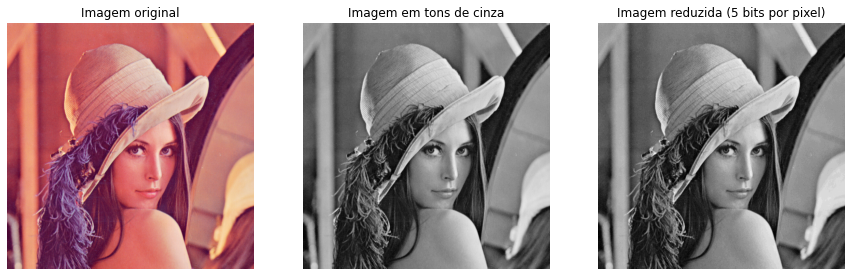

In [12]:
img = cv2.imread(input_filepath)
plt.figure(figsize=(15, 6))

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 1)
plt.title('Imagem original')
plt.axis('off')
plt.imshow(rgb_img)

gs_img = convert_to_grayscale(img)
plt.subplot(1, 3, 2)
plt.title('Imagem em tons de cinza')
plt.axis('off')
plt.imshow(gs_img, cmap='gray')

reduced_img = reduce_channel_range(gs_img, 3)
plt.subplot(1, 3, 3)
plt.title('Imagem reduzida (5 bits por pixel)')
plt.axis('off')
plt.imshow(reduced_img, cmap='gray')

plt.show()

Observe como a qualidade da imagem reduzida cai (exponencialmente) conforme removemos mais bits.

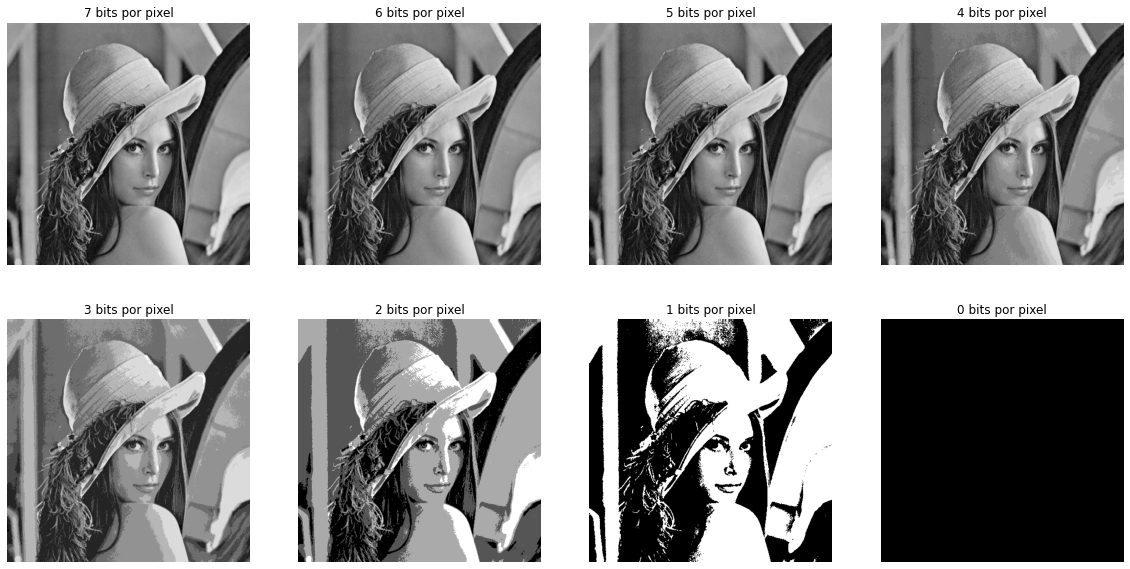

In [13]:
plt.figure(figsize=(20, 10))

for i in range(1, 9):
  plt.subplot(2, 4, i)
  plt.title(f'{8-i} bits por pixel')
  plt.axis('off')
  plt.imshow(reduce_channel_range(gs_img, i), cmap='gray')

plt.show()

Abaixo, podemos observar como a redução do número de bits por pixel afeta a distribuição de tons da imagem:

In [14]:
original_df = pixel_distribution(gs_img).sort_values('Intensidade do Pixel')
reduced_df = pixel_distribution(reduced_img).sort_values('Intensidade do Pixel')

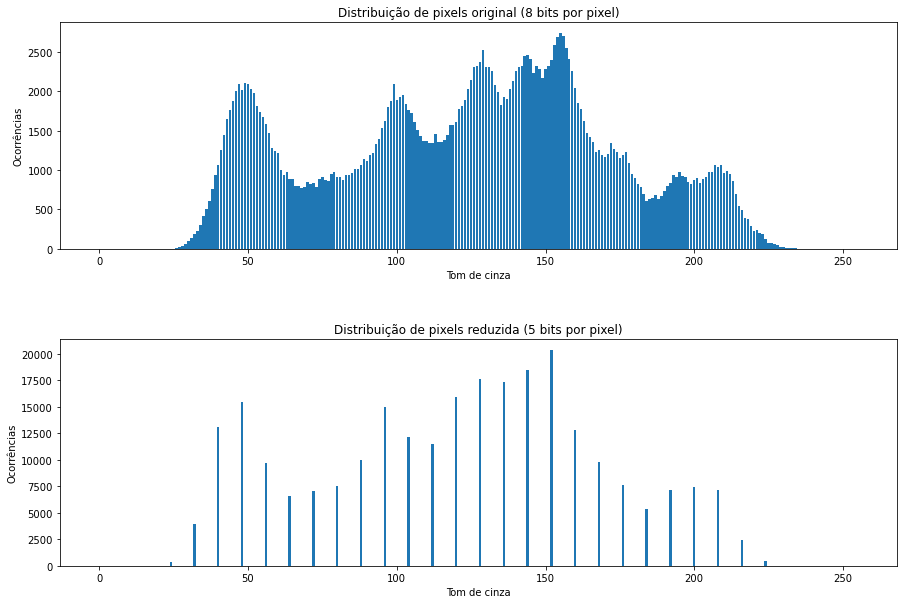

In [15]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title('Distribuição de pixels original (8 bits por pixel)')
plt.gca().set_xlabel('Tom de cinza')
plt.gca().set_ylabel('Ocorrências')
plt.bar(original_df['Intensidade do Pixel'], original_df['Ocorrencias'])

plt.subplot(2, 1, 2)
plt.title('Distribuição de pixels reduzida (5 bits por pixel)')
plt.gca().set_xlabel('Tom de cinza')
plt.gca().set_ylabel('Ocorrências')
plt.bar(reduced_df['Intensidade do Pixel'], reduced_df['Ocorrencias'])

plt.subplots_adjust(hspace=.4)
plt.show()

Como podemos observar, a probabilidade de muitos pixeis se torna zero, assim, diminuímos a frequência da nossa imagem e tornamos mais eficientes os próximos passos.

## Transformada Discreta do Cosseno

DCT, do inglês, Discrete Cosine Transform é uma transformada, cuja aplicação resulta na alteração da representação inicial da imagem, provendo informações que permitam uma análise mais profunda dos dados. As funções `get_2D_dct` e `get_2d_idct` implementam a transformada e sua inversa por meio da biblioteca **scipy**.

In [16]:
def get_2D_dct(img):
  """ Get 2D Cosine Transform of Image
  """
  return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
  """ Get 2D Inverse Cosine Transform of Image
  """
  return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def img_transform(img, step=8):
  cp_img = img.astype(float) - 128
  size = cp_img.shape
  transform = np.zeros(size, dtype=float)

  for y in range(0, size[0], step):
    for x in range(0,size[1],step):
      dct = get_2D_dct(cp_img[y:y+step, x:x+step])
      transform[y:y+step, x:x+step] = dct

  return transform

def img_inverse_transform(transform, step=8):
  size = transform.shape
  inverse_transform = np.zeros(size, dtype=float)

  for y in range(0, size[0], step):
    for x in range(0,size[1],step):
      idct = get_2d_idct(transform[y:y+step, x:x+step])
      inverse_transform[y:y+step, x:x+step] = idct
  return inverse_transform + 128

Abaixo temos o resultado. A esquerda a imagem resultante da transformada, a direita a imagem reconstruída dessa transformada, observe que se trata de uma codificação sem perdas.

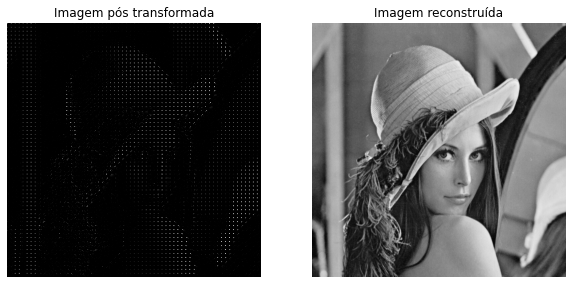

In [17]:
plt.figure(figsize=(10, 6))

transform = img_transform(gs_img)
plt.subplot(1, 2, 1)
plt.title('Imagem pós transformada')
plt.axis('off')
plt.imshow(transform, cmap='gray', clim=(0, 255))

inverse_transform = img_inverse_transform(transform)
plt.subplot(1, 2, 2)
plt.title('Imagem reconstruída')
plt.axis('off')
plt.imshow(inverse_transform, cmap='gray')
plt.show()

A DCT apresenta propriedade de compactação da energia em regiões próximas a origem. De posse dessa compactação, após a execução desta, múltiplos coeficiente terão valores próximos a zero e estes podem ser descartados sem perda significativa de informação. Também arredondaremos valores para inteiros com o intuito de futuramenta fazer a codificação de comprimento de corrida.

In [18]:
def eliminate_low_frequencies(img, zero_threshold = 30, upper_threshold = 1023):
  
  converted_img = np.zeros(img.shape, dtype = int)  
  for idx_r, line in enumerate(img): 
    for idx_c, pixel in enumerate(line): 
      if (abs(pixel) < zero_threshold): 
        converted_img[idx_r][idx_c] = 0
      elif (pixel > upper_threshold):
         converted_img[idx_r][idx_c] = upper_threshold
      else:
        converted_img[idx_r][idx_c] = pixel
  return converted_img

Abaixo o resultado dessa compressão, observe que agora temos perda na qualidade da reconstrução. O nível da perda pode ser controlado pelos parâmetros `zero_threshold` e `upper_threshold`

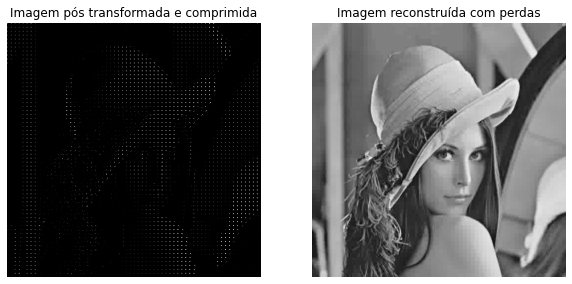

In [19]:
plt.figure(figsize=(10, 6))

high_f = eliminate_low_frequencies(transform)
plt.subplot(1, 2, 1)
plt.title('Imagem pós transformada e comprimida')
plt.axis('off')
plt.imshow(high_f, cmap='gray', clim=(0, 255))


high_f_inverse = img_inverse_transform(high_f) 
plt.subplot(1, 2, 2)
plt.title('Imagem reconstruída com perdas')
plt.axis('off')
plt.imshow(high_f_inverse, cmap='gray')
plt.show()

# TODO: Comparar com mais parâmetros de threshold

## Codificação por Comprimento de corrida

Esta codificação armazena a quantidade de pixeis iguais em sequênica assim explorando a _redundância interpixel_. A codificação pode ser vista na função `run_length_encoding` e a decodificação na função `run_length_dencoding`. 

In [20]:
def run_length_encoding(img):

  new_img = []
  for idx_r, line in enumerate(img): 
    new_img.append([])
    idx_c = 0; current_run = 0; ini = line[idx_c]
    while(idx_c < len(line)):                          
      
      if (line[idx_c] != ini):                      
        new_img[idx_r].append((ini, current_run)) 
        ini = line[idx_c]; current_run = 0                        
      
      idx_c += 1; current_run += 1     
    new_img[idx_r].append((ini, current_run))           
  
  return np.array([np.array(xi, dtype=int) for xi in new_img], dtype=object)

def run_length_dencoding(img):
  
  converted_img = []
  for idx_r, line in enumerate(img): 
    converted_img.append([])
    for idx_c, pair in enumerate(line): 
      for _ in range(pair[1]):
        converted_img[idx_r].append(pair[0])

  return np.array([np.array(xi) for xi in converted_img])

A partir dessa codificação, podemos reconstruir a imagem sem perdas:

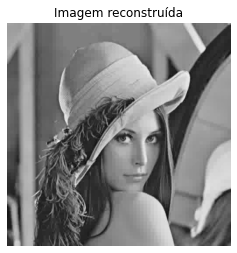

In [21]:
encoded_img = run_length_encoding(high_f)
decoded_img = run_length_dencoding(encoded_img)
reconstructed =  img_inverse_transform(decoded_img)

plt.figure(figsize=(4, 6))
plt.title('Imagem reconstruída')
plt.axis('off')
plt.imshow(high_f_inverse, cmap='gray')
plt.show()

### Codificação binária do comprimento de corrida

Antes da última etapa da compressão, onde executaremos o algoritmo de huffman, precisamos criar uma representação binária da imagem codificada em comprimento de corrida obtida. Essa representação se dá da seguinte forma:

1. Os primeiros 2 bytes representam um offset adicionado a todos os valores de tonalidade. Isso é feito para remover números negativos e eliminar a necessidade de representar números com sinais.

2. Os próximos 3 bytes do arquivo indicam o número de linhas da imagem, com ele podemos identificar as dimensões da imagem reconstruída como: $$c = \frac{s}{r}$$ onde $s$ é a quantidade total de bits decodificados para a imagem (após aplicação da inversa do comprimento de corrida) e $r$ é o número de linhas lido.

3. O sexto byte indica o valor de $t$ = quantidade de bits utilizados para representar cada tonalidade de cinza.

4. O sétimo byte indica o valor de $l$ = quantidade de bits utilizados para representar cada comprimento de corrida.

5. Os bits seguintes devem ser lidos em passos de $t$ e $l$, eles representam tuplas de (tonalidade, comprimento). Ao fim do arquivo, podem existir de 0 a 7 bits de padding para completar um byte, eles podem ser identificados por $c = 0$ e devem ser descartados.

A função `binary_encoding` realiza essa codificação e retorna uma lista de bits. A função `binary_decoding` realiza a operação inversa e retorna a lista de listas de tuplas pronta para ser decodificada no comprimento de corrida.


In [22]:
def binary_run_length_encoding(run_length):
  rows = run_length.shape[0]

  offset = abs(int(np.min([min(row, key=lambda row: row[1]) for row in run_length])))
  offset_run_length = np.array([np.array([(pair[0] + offset, pair[1]) for pair in row]) for row in run_length], dtype=object)

  max_run = int(np.max([max(row, key=lambda row: row[1]) for row in offset_run_length]))
  max_level = int(np.max([max(row, key=lambda row: row[0]) for row in offset_run_length]))
  max_run_num_bits = max_run.bit_length()
  max_level_num_bits = max_level.bit_length()

  bits = []
  bits += to_bits(offset, 16)
  bits += to_bits(rows, 24)
  bits += to_bits(max_level_num_bits, 8)
  bits += to_bits(max_run_num_bits, 8)

  for line in offset_run_length:
    for pair in line:
      bits += to_bits(int(pair[0]), max_level_num_bits)
      bits += to_bits(int(pair[1]), max_run_num_bits)

  return bits

def binary_run_length_decoding(bits):
  sequence = []
  decoded = []
  sequence_length = 0

  offset = to_decimal(bits[0:16])
  rows = to_decimal(bits[16:40])
  shade_num_bits = to_decimal(bits[40:48])
  length_num_bits = to_decimal(bits[48:56])

  for i in range(56, len(bits), (shade_num_bits + length_num_bits)):
    shade_final_index = i + shade_num_bits
    length_final_index = shade_final_index + length_num_bits

    if len(bits) >= length_final_index:
      shade = to_decimal(bits[i:shade_final_index]) - offset
      length = to_decimal(bits[shade_final_index : length_final_index])
      if(length > 0):
        sequence.append((shade, length))
        sequence_length += length
    
  columns = int(sequence_length/rows)
  current_row_length = 0
  decoded = [[]]
  for run in sequence:
    if current_row_length + run[1] <= columns:
      current_row_length += run[1]
      decoded[-1].append(run)

    else:
      if current_row_length != columns: 
        raise AssertionError('Número de colunas incompleto')
      current_row_length = run[1]
      decoded.append([run])

  return np.array([np.array(xi) for xi in decoded], dtype=object)

Executando as duas funções, podemos verificar que de fato obtemos o item inicial após a codificação e decodificação. O bloco abaixo lançaria uma excessão caso contrário:

In [23]:
binary = binary_run_length_encoding(encoded_img)
decoded_binary = binary_run_length_decoding(binary)

if encoded_img.shape != decoded_binary.shape:
  raise AssertionError('Elements are not equal')

for i in range(encoded_img.shape[0]):
  for (a, b) in zip(encoded_img[i], decoded_binary[i]):
    if (a != b).any():
      print(f'{i}:', a, b)
      raise AssertionError('Elements are not equal')

## Codificação por Huffman

Passando como argumento o dataframe gerado pela função  `pixel_distribution`, a função a seguir é capaz de gerar um código binário para cada um dos tons de ciza presente na imagem. Esse código depende da probabilidade de ocorrência do tom na imagem, sendo essa a principal característica da codificação por huffman.

In [24]:
def huffman(df, upper_threshold = 256):

    frequencias = defaultdict(float)
    for i in range(0,upper_threshold):
        if df.loc[i]["Probabilidade"] >0:
            frequencias[i] = df.loc[i]["Probabilidade"]
    
    heap = [[prob, [simbolo, ""]] for simbolo, prob in frequencias.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for par in lo[1:]:
            par[1] = '0' + par[1]
        for par in hi[1:]:
            par[1] = '1' + par[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    huffman = sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p));
    
    dic = {}
    df["Codigo Huffman"] = None
    for pixel, cod in huffman:
        df.loc[pixel, "Codigo Huffman"] = cod
        dic[pixel] = cod
        
    return df, dic

### Árvore de Huffman

Para decodificar uma imagem em binário, é necessário utilizar uma árvore em que cada folha guardará uma intensidade de tom de cinza. A classe _Node_ a seguir representa um nó da árvore e a função `create_tree` recebe um dicionário e cria a árvore de Huffman correspondente.

In [25]:
class Node:

    def __init__(self):

        self.left = None
        self.right = None
        self.leaf = False
        self.value = -1

def create_tree(dic):
    
    root = Node()
    for key, v in dic.items():

        actual_node = root
        value = str(v)
        for i in range(len(value)):
            if value[i] == "0":
                if actual_node.left == None:
                    actual_node.left = Node()
                actual_node = actual_node.left
            else:
                if actual_node.right == None:
                    actual_node.right = Node()
                actual_node = actual_node.right

        actual_node.leaf = True
        actual_node.value = int(key)

    return root

### Inversa de Huffman

Para decodificação do arquivo binário, deve-se construir a árvore de Huffman equivalente ao mapeamento de tons de cinza para código binário. Assim, utiliza-se a árvore para processar o código binário que representa a imagem, sendo que com isso é possivel realizar a sua recuperação. A função `huffman_inversa` é responsável por fazer esse processamento.

In [26]:
def huffman_inversa(rows, columns, dic, code):
    img_decoded = np.zeros((rows, columns), dtype = np.uint8)
    tree = create_tree(dic)

    x, y = 0, 0
    i = 0
    for x in range(img_decoded.shape[0]):
      for y in range(img_decoded.shape[1]):
        actual_node = tree
        
        while actual_node.leaf != True:
            if code[i] == "0":
                actual_node = actual_node.left
            else:
                actual_node = actual_node.right
            i += 1
        
        img_decoded[x, y] = actual_node.value
            
    return img_decoded

### Codificação binário do método de Huffman

Para codificação e decodificação do método de Huffman, adotou-se uma representação para escrita e leitura do arquivo binário. Essa representação se dá da seguinte forma:

1. Os primeiros 2 bytes do arquivo representam o número de linhas da imagem.

2. Os próximos 2 bytes indicam o número de colunas.

3. Já o quinto byte indica o tamanho do dicionário que guarda o mapeamento de tons de cinza para códigos binários

4. Os próximos bits resultam de uma iteração com número de repetições igual ao tamanho do dicionário. O padrão adotado foi o seguinte: o primeiro byte representa o tom de cinza, os próximos 5 bits representam o tamanho do código de huffman (n), sendo que esse tamanho será usado para indicar que os próximos n bits se referem ao código de Huffman para o tom de cinza em questão.

5. Os demais bits até o final do arquivo guardam os pixels da imagem codificados usando o método de Huffman.

As funções `huffman_encode` e `huffman_decode` a seguir usam dessa representação para codificar e decodificar o arquivo binário.

In [27]:
def huffman_encode(img, dic):
    
    rows, columns = img.shape
    symbols = ""
    for line in img:
        for pixel in line:
            symbols += dic[pixel]

    bits = []
    bits += to_bits(rows, 16)
    bits += to_bits(columns, 16)
    bits += to_bits(len(dic), 8)

    for k, v in dic.items():
      bits += to_bits(k, 8)
      bits += to_bits(len(v), 5)
      bits += to_bits(int(v, 2), len(v))

    for line in img:
        for pixel in line:
            code = dic[pixel]
            bits += to_bits(int(code, 2), len(code))

    return bits

def huffman_decode(bits):

    rows = to_decimal(bits[0:16])
    columns = to_decimal(bits[16:32])

    dict_size = to_decimal(bits[32:40])

    dic = {}

    i = 40
    for _ in range(dict_size):
      key = to_decimal(bits[i:i+8])
      i += 8
      code_length = to_decimal(bits[i:i+5])
      i += 5
      code = to_decimal(bits[i:i+code_length])
      i += code_length

      dic[key] = ''.join([str(bit) for bit in to_bits(code, code_length)])

    code = ''.join([str(b) for b in bits[i:]])

    return rows, columns, dic, code

## Saída do método

Por fim, escrevemos os bits da saída resultante do método em um arquivo através da função `write_encoding_to_file`.

In [28]:
def write_encoding_to_file(bits, file_name):
  f = open(file_name, "wb")
  pad = (8 - (len(bits) % 8)) % 8
  padded_bits = bits + [0 for i in range(pad)]

  f.write(pad.to_bytes(1, 'little'))
  for i in range(0, len(padded_bits), 8):
    byte = to_decimal(padded_bits[i:i+8])
    f.write(byte.to_bytes(1, "little"))

  f.close()

def read_encoding_from_file(fileName):
  f = open(fileName, "rb")
  pad = int.from_bytes(f.read(1), 'little')

  bits = []
  byte = f.read(1)
  while byte:
    bits += to_bits(int.from_bytes(byte, "little"), 8)
    byte = f.read(1)

  f.close()
  return bits[0:-pad] if pad != 0 else bits

## Métodos para compressão

### Primeiro Método: Codificação de Huffman

Chamaremos nosso primeiro pipeline, ```first_method```, este recebe a imagem original em _Gray Scale_ e explora a redundância de codificação realizando a codificação de _Huffman_. A função ```first_method_inverse``` recebe a imagem comprimida e faz esta retornar ao estado original.  

In [29]:
def first_method(gs_img, file_name):

  df = pixel_distribution(gs_img, 256)
  df, dic = huffman(df)
  bits = huffman_encode(gs_img, dic)
  write_encoding_to_file(bits, file_name)

def first_method_inverse(file_name):
  bits = read_encoding_from_file(file_name)
  rows, columns, dic, code = huffman_decode(bits)

  return huffman_inversa(rows, columns, dic, code)

Abaixo podemos observar tanto a imagem original em _gray scale_ quanto a imagem após passar pelo segundo método e sua inversa:


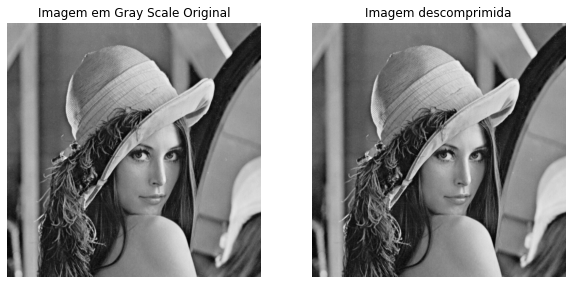

In [30]:
first_method(gs_img, output_filepath_m1)
decompressed_img = first_method_inverse(output_filepath_m1)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Imagem em Gray Scale Original')
plt.axis('off')
plt.imshow(gs_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Imagem descomprimida')
plt.axis('off')
plt.imshow(decompressed_img, cmap='gray')
plt.show()

Abaixo podemos ver a taxa de compressão, obtida com a função utilitária ```compression_rate``` e a diferença global entre duas imagens, obtida com a função utilitária ```psnr```.

In [31]:
c_rate = compression_rate(gs_img, output_filepath_m1)
rmse = root_mean_square_error(gs_img, decompressed_img)

print("Taxa de compressão: ", c_rate)
print("RMSE: ", rmse)

Taxa de compressão:  1.0687584342728078
RMSE:  0.0


### Segundo Método: Redução de Canais e Codificação de Huffman

Agora chamaremos nosso segundo pipeline, ```second_method```, este recebe a imagem original em _Gray Scale_, aplica a função ```reduce_channel_range``` para diminuir a profundidade do nível de cinza, e explora a redundância de codificação realizando a _codificação de Huffman_. A função ```second_method_inverse``` recebe a imagem comprimida e faz esta retornar ao estado original.  

In [32]:
def second_method(gs_img, file_name):

  reduced_img = reduce_channel_range(gs_img, 3)
  df = pixel_distribution(reduced_img, 256)
  df, dic = huffman(df)
  bits = huffman_encode(reduced_img, dic)
  write_encoding_to_file(bits, file_name)

def second_method_inverse(file_name):
  bits = read_encoding_from_file(file_name)
  rows, columns, dic, code = huffman_decode(bits)
  img = huffman_inversa(rows, columns, dic, code)

  return img

Abaixo podemos observar tanto a imagem original em _gray scale_ quanto a imagem após passar pelo segundo método e sua inversa:


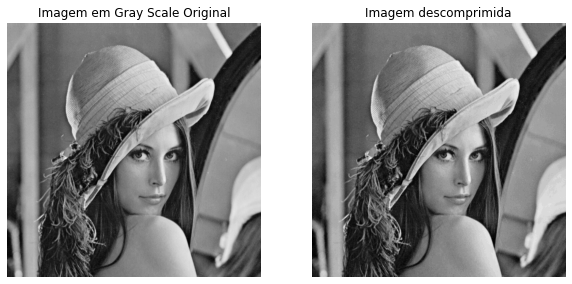

In [33]:
second_method(gs_img, output_filepath_m2)
decompressed_img = second_method_inverse(output_filepath_m2)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Imagem em Gray Scale Original')
plt.axis('off')
plt.imshow(gs_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Imagem descomprimida')
plt.axis('off')
plt.imshow(decompressed_img, cmap='gray')
plt.show()

Abaixo podemos ver a taxa de compressão, obtida com a função utilitária ```compression_rate``` e a diferença global entre duas imagens, obtida com a função utilitária ```psnr```.

In [34]:
c_rate = compression_rate(gs_img, output_filepath_m2)
rmse = root_mean_square_error(gs_img, decompressed_img)

print("Taxa de compressão: ", c_rate)
print("RMSE: ", rmse)
print("PSNR: ", psnr(rmse))

Taxa de compressão:  1.7822619573715879
RMSE:  4.178417775888773
PSNR:  35.71056640037729


### Terceiro Método: Comprimento de Corrida em transformada DCT

Agora chamaremos nosso terceiro pipeline, ```third_method```, este recebe a imagem original em _Gray Scale_, aplica a transformada discreta do cosseno, elimina valores próximos a 0, igualando estes a 0 e aplica a codificação de comprimento de corrida explorando a _redundância interpixel_. A função ```third_method_inverse``` recebe a imagem comprimida e faz esta retornar ao estado original.  

In [35]:
def third_method(img, file_name = 'out.compressed'):
  transformed_img = img_transform(img)
  compressed_transformed_img = eliminate_low_frequencies(transformed_img, 30)
  compressed_img = run_length_encoding(compressed_transformed_img)
  compressed_binary_img = binary_run_length_encoding(compressed_img)
  write_encoding_to_file(compressed_binary_img, file_name)


def third_method_inverse(file_name = 'out.compressed'):
  reconstructed_img = read_encoding_from_file(file_name)
  reconstructed_img = binary_run_length_decoding(reconstructed_img)
  reconstructed_img = run_length_dencoding(reconstructed_img)
  reconstructed_img = img_inverse_transform(reconstructed_img)
  
  return reconstructed_img

Abaixo podemos observar tanto a imagem original em _gray scale_ quanto a imagem após passar pelo terceiro método e sua inversa:

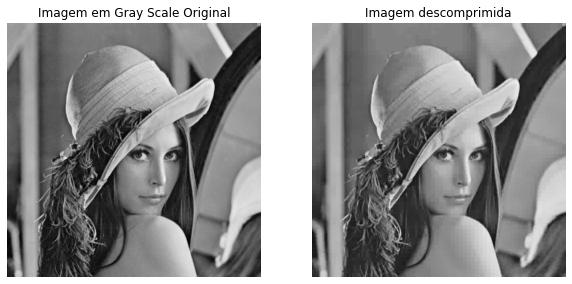

In [36]:
third_method(gs_img, output_filepath_m3)
decompressed_img = third_method_inverse(output_filepath_m3)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Imagem em Gray Scale Original')
plt.axis('off')
plt.imshow(gs_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Imagem descomprimida')
plt.axis('off')
plt.imshow(decompressed_img, cmap='gray')
plt.show()

Abaixo podemos ver a taxa de compressão, obtida com a função utilitária ```compression_rate``` e a diferença global entre duas imagens, obtida com a função utilitária ```psnr```.

In [37]:
c_rate = compression_rate(gs_img, output_filepath_m3)
rmse = root_mean_square_error(gs_img, decompressed_img)

print("Taxa de compressão: ", c_rate)
print("RMSE: ", rmse)
print("PSNR: ", psnr(rmse))

Taxa de compressão:  5.1054415144315035
RMSE:  5.579374107545456
PSNR:  33.19909395568071


### Quarto Método: Redução de Canais e Comprimento de Corrida em transformada DCT

Agora chamaremos nosso quarto pipeline, ```fourth_method```, este recebe a imagem original em _Gray Scale_, utiliza a função ```reduce_channel_range``` para reduzir a profundidade de niveis de cinza, aplica a transformada discreta do cosseno, elimina valores próximos a 0, igualando estes a 0 e aplica a codificação de comprimento de corrida explorando a _redundância interpixel_. A função ```fourth_method_inverse``` recebe a imagem comprimida e faz esta retornar ao estado original.  

In [38]:
def fourth_method(gs_img, file_name = 'out.compressed'):
  reduced_img = reduce_channel_range(gs_img, 3)
  transformed_img = img_transform(reduced_img)
  compressed_transformed_img = eliminate_low_frequencies(transformed_img, 30)
  compressed_img = run_length_encoding(compressed_transformed_img)
  compressed_binary_img = binary_run_length_encoding(compressed_img)
  write_encoding_to_file(compressed_binary_img, file_name)

def fourth_method_inverse(file_name = 'out.compressed'):
  reconstructed_img = read_encoding_from_file(file_name)
  reconstructed_img = binary_run_length_decoding(reconstructed_img)
  reconstructed_img = run_length_dencoding(reconstructed_img)
  reconstructed_img = img_inverse_transform(reconstructed_img)
  
  return reconstructed_img

Abaixo podemos observar tanto a imagem original em _gray scale_ quanto a imagem após passar pelo terceiro método e sua inversa:

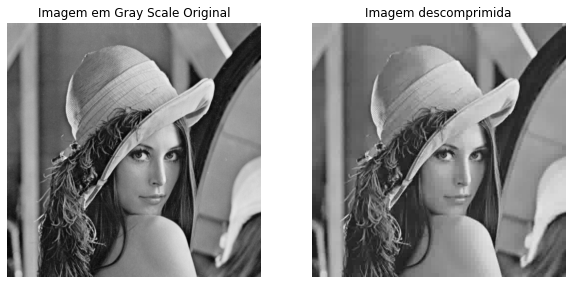

In [39]:
fourth_method(gs_img, output_filepath_m4)
decompressed_img = fourth_method_inverse(output_filepath_m4)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Imagem em Gray Scale Original')
plt.axis('off')
plt.imshow(gs_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Imagem descomprimida')
plt.axis('off')
plt.imshow(decompressed_img, cmap='gray')
plt.show()

Abaixo podemos ver a taxa de compressão, obtida com a função utilitária ```compression_rate``` e a diferença global entre duas imagens, obtida com a função utilitária ```psnr```.

In [40]:
c_rate = compression_rate(gs_img, output_filepath_m4)
rmse = root_mean_square_error(gs_img, decompressed_img)

print("Taxa de compressão: ", c_rate)
print("RMSE: ", rmse)
print("PSNR: ", psnr(rmse))

Taxa de compressão:  5.046957124429642
RMSE:  6.58475653740653
PSNR:  31.760009165974576


## Conclusão

As métricas obtidas variam de acordo com as carcterísticas de imagem de entrada, contudo, ao analisarmos nos testes realizados as métricas propostas, taxa de compressão e PSNR, concluimos que o método mais eficiente é o terceiro, comprimento de corrida na transformada do cosseno. Ainda que a diferença de taxa de compressão para o quarto método, comprimento de corrida em transformada discreta do cosseno com redução de canal, seja mínima, o terceiro método apresenta um PSNR melhor para os testes realizados. É interessante compararmos com os resultados obtidos com a codificação de Huffman, que apresentaram indíces de compressão extremamente baixos, contudo tendem a melhorar conforme as dimensões da imagem aumentam.